In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import hfmfit as hf

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 300
signal_to_noise = 4


nsamples = 20
L = 4

ranks = np.array([4, 3, 2, 1])
rank = ranks.sum()

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 9, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = hf.print_hpart_numgroups(hpart)

level=0, num_groups=1, mean_size=300.0
level=1, num_groups=4, mean_size=75.0
level=2, num_groups=8, mean_size=37.5
level=3, num_groups=300, mean_size=1.0


In [5]:
true_mlr, true_sparse_F, true_D_noise = hf.generate_mlr_model(n, hpart, ranks, signal_to_noise)

signal_var=8.837876183246516, noise_var=2.2576120524425716
SNR=3.9147010106030304, signal_to_noise=4


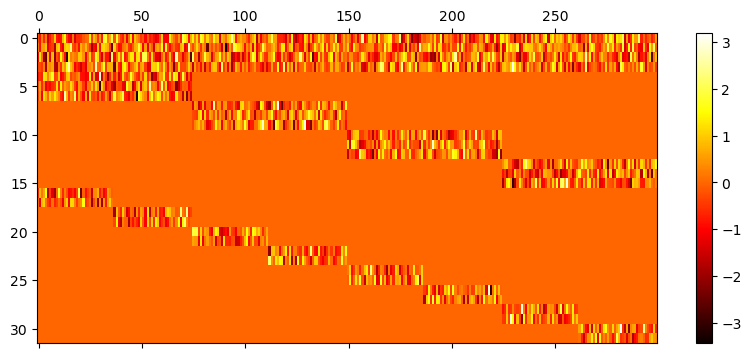

(300, 32)


In [6]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [7]:
type(true_sparse_F)

numpy.ndarray

In [9]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [10]:
row_selectors, si_groups, F_hpart = hf.row_col_selections(hpart)

num_levels=4, num_sparsities=8
(8, 3) [0 3 7]


# True model loglikelihoods

In [14]:
C = hf.generate_data(true_sparse_F, true_D_noise, nsamples, true_mlr)
Z = (C - C.mean(axis=1, keepdims=True))[hpart["rows"]["pi"], :]
del C
unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[true_mlr.pi_inv_rows, :][:, true_mlr.pi_inv_cols]
# permute to put clusters on diagonal
Y = Z.T
N = Y.shape[0]

true_Sigma = hf.perm_hat_Sigma_sp(true_sparse_F, true_D_noise)
tr_lu, tr_piv = scipy.linalg.lu_factor(true_Sigma)
true_train_obj = hf.loglikelihood_value(true_Sigma, tr_lu, tr_piv, Y)
exp_true_ll = hf.exp_true_loglikelihood_value(true_Sigma)
print(f"TR: train ll={true_train_obj}, exp ll={exp_true_ll}")

TR: train ll=-559.1507748088661, exp ll=-566.1412192162936


In [15]:
assert np.allclose(exp_true_ll, hf.exp_loglikelihood_value(true_Sigma, true_Sigma, tr_lu, tr_piv))

In [16]:
np.linalg.slogdet(true_Sigma), true_sparse_F.shape

((1.0, 280.9193185097838), (300, 32))

# Distribution of $\mathbf{E}_y\ell(\theta(Y^{\text{train}}); y)$

In [17]:
ll_distribution = {"frob":{"train":[], "exp":[]},
                   "mle":{"train":[], "exp":[]}}

In [49]:
for t in range(200):
    print(f"{t=}")
    C = hf.generate_data(true_sparse_F, true_D_noise, nsamples, true_mlr)
    Z = (C - C.mean(axis=1, keepdims=True))[hpart["rows"]["pi"], :]
    del C
    unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[true_mlr.pi_inv_rows, :][:, true_mlr.pi_inv_cols]
    # permute to put clusters on diagonal
    Y = Z.T
    N = Y.shape[0]

    # Frobenius 
    hat_A = mf.MLRMatrix()
    hat_A.hpart = hpart
    losses = hat_A.factor_fit(unpermuted_A, ranks, hat_A.hpart, eps_ff=1e-3, PSD=True, freq=1, \
                                    printing=False, max_iters_ff=50, symm=True)
    F_frob, D_frob = hat_A.B[:, :-1], np.square(hat_A.B[:, -1])
    Sigma_frob = hf.perm_hat_Sigma(F_frob, D_frob, F_hpart, ranks)
    frob_lu, frob_piv = scipy.linalg.lu_factor(Sigma_frob)
    obj_frob = hf.loglikelihood_value(Sigma_frob, frob_lu, frob_piv, Y)
    exp_obj_frob = hf.exp_loglikelihood_value(true_Sigma, Sigma_frob, frob_lu, frob_piv)
    print(f"FR: train ll={obj_frob}, exp ll={exp_obj_frob}, {losses[-1]=}")
    ll_distribution["frob"]["train"] += [obj_frob]
    ll_distribution["frob"]["exp"] += [exp_obj_frob]

    # MLE
    loglikelihoods, F0, D0 = hf.em_algorithm(n, Y, part_sizes, F_hpart, row_selectors, si_groups, 
                                         ranks, max_iter=100, eps=1e-8, printing=False, freq=1) 
    Sigma0 = hf.perm_hat_Sigma(F0, D0, F_hpart, ranks)
    mle_lu, mle_piv = scipy.linalg.lu_factor(Sigma0)
    exp_mle_obj = hf.exp_loglikelihood_value(true_Sigma, Sigma0, mle_lu, mle_piv)
    print(f"ML: train ll={loglikelihoods[-1]}, exp ll={exp_mle_obj}")
    ll_distribution["mle"]["train"] += [loglikelihoods[-1]]
    ll_distribution["mle"]["exp"] += [exp_mle_obj]

t=0
FR: train ll=-496.18348457293206, exp ll=-1354.1583594983877, losses[-1]=0.3876368384519186
ML: train ll=-450.49566775685224, exp ll=-1201.4661122331124
t=1
FR: train ll=-493.6466977893409, exp ll=-1136.8355217943385, losses[-1]=0.32778325355216187
ML: train ll=-457.79878032220756, exp ll=-1116.4723128475866
t=2
FR: train ll=-498.0060211214366, exp ll=-1526.0192300259698, losses[-1]=0.363159034866746
ML: train ll=-449.2063117074752, exp ll=-1279.7228418900177
t=3
FR: train ll=-490.18687899257156, exp ll=-1172.6265292806265, losses[-1]=0.373125377453875
ML: train ll=-452.9724354685086, exp ll=-1332.3692212159904
t=4
FR: train ll=-505.93012426968016, exp ll=-1557.1892473603496, losses[-1]=0.3422445889466911
ML: train ll=-449.1697115514623, exp ll=-1173.1854691584683
t=5
FR: train ll=-499.27086835042854, exp ll=-1157.1043608206273, losses[-1]=0.34115754239046053
ML: train ll=-451.47118798930205, exp ll=-1142.3852280911206
t=6
FR: train ll=-490.4178891847646, exp ll=-1229.7837559393945

In [62]:
with open(f"outputs/hist_ll_{filename}.pickle", 'wb') as handle:
    pickle.dump(ll_distribution, handle, protocol=pickle.HIGHEST_PROTOCOL)

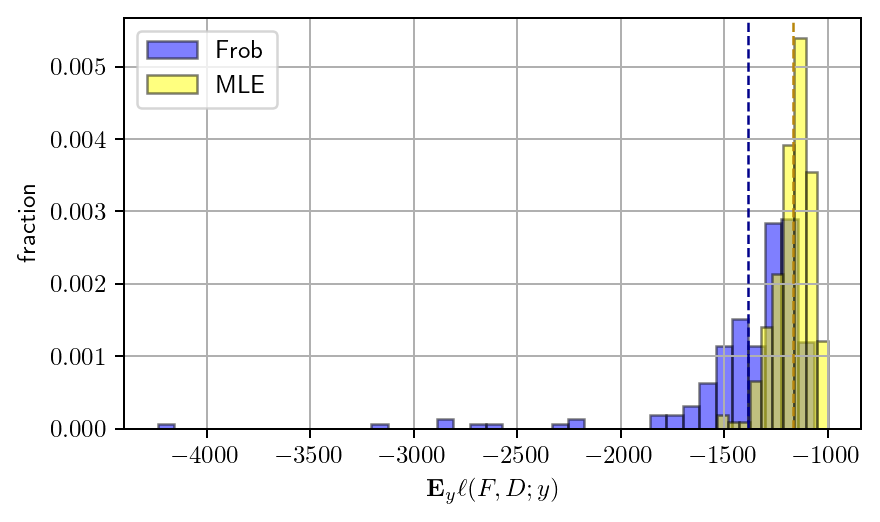

In [64]:
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}"
})
fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=180, sharey=True)

mean1, std1 = np.mean(ll_distribution["frob"]["exp"]), np.std(ll_distribution["frob"]["exp"])
mean2, std2 = np.mean(ll_distribution["mle"]["exp"]), np.std(ll_distribution["mle"]["exp"])

plt.hist(ll_distribution["frob"]["exp"], bins=40, alpha=0.5, color='blue', label='Frob', density=True, edgecolor='black')
plt.hist(ll_distribution["mle"]["exp"], bins=10, alpha=0.5, color='yellow', label='MLE', density=True, edgecolor='black')

plt.axvline(mean1, color='darkblue', linestyle='--', linewidth=1)
plt.axvline(mean2, color='darkgoldenrod', linestyle='--', linewidth=1)

# plt.title('Distribution of expected log-likelihoods')
plt.xlabel(r'$\mathbf{E}_y \ell(F, D; y)$')
plt.ylabel('fraction')
plt.legend()

axs.grid(True)
plt.tight_layout()
plt.savefig(f"plots/hist_{filename}.pdf", bbox_inches='tight')